# 手撕 DPO

$$\mathcal{L}_{DPO}(\pi;\pi_{ref}) = -\mathbb{E}_{(a, y_w, y_l)_{\sim}\mathcal{D}}[\log \sigma(\beta\log\frac{\pi_\theta%(y_w|x)}{\pi_{\text{ref}}(y_w|x)}-\beta\log\frac{\pi_\theta(y_l|x)}{\pi_{\text{ref}}(y_l|x)})]$$

In [1]:
import torch
import torch.nn.functional as F
from transformers import LlamaConfig, LlamaForCausalLM
torch.manual_seed(42)

# 加载模型
config = LlamaConfig(vocab_size = 32,      # default is 32000
                    hidden_size = 256,
                    intermediate_size = 512,
                    num_hidden_layers = 2,
                    num_attention_heads = 4,
                    num_key_value_heads = 4,
                    )
ref_model = LlamaForCausalLM(config)
ref_model.eval()
model = LlamaForCausalLM(config)
print(model.lm_head)

Linear(in_features=256, out_features=32, bias=False)

In [2]:
# Create Preference data
# Chosen :   [Prompt Token,  Response Chosen Token]
# Rejected :   [Prompt Token,  Response Rejected Token]

prompt_length = 6
answer_length = 4
prompt_chosen =   torch.tensor([[5, 8, 9, 10, 5, 3,   16, 29, 18, 17]], dtype=torch.int64)
prompt_rejected = torch.tensor([[5, 8, 9, 10, 5, 3,   26, 14, 31, 0]], dtype=torch.int64)
attention_mask =  torch.tensor([[1, 1, 1, 1,  1, 1,   1,  1,  1,  1]], dtype=torch.bool)
label =  torch.tensor([[0, 0, 0, 0,  0, 0,   1,  1,  1,  1]], dtype=torch.bool)

x_chosen = {'input_ids':prompt_chosen, 'attention_mask':attention_mask}
x_rejected = {'input_ids':prompt_rejected, 'attention_mask':attention_mask}

In [3]:
# Calculative Token-Level Policy 

# test for get logits and logprob
output = ref_model(**x_chosen)
print(output.logits.shape)
print(output.logits[0,8,:])
print(output.logits.shape)

# how DPO get target policy
# output.logits.log_softmax(-1)
def get_probs(logits, labels):
    per_token_logps = torch.gather(logits.log_softmax(-1), dim=2, 
                                   index=labels.unsqueeze(2)).squeeze(2)
    return per_token_logps
    
probs_chosen = get_probs(output.logits, prompt_chosen)
print(probs_chosen)

torch.Size([1, 10, 32])

tensor([ 0.2335,  0.3941,  0.1202,  0.4387, -0.1524, -0.3459,  0.2171,  0.3140,
         0.2178,  0.5960, -0.2206,  0.0274, -0.1299, -0.1082, -0.3908,  0.0251,
         0.0717, -0.0511,  0.4666, -0.1745, -0.0081, -0.2010,  0.7499, -0.0554,
         0.1489, -0.0237, -0.0649,  0.4780, -0.2939,  0.1238, -0.3048, -0.2033],
       grad_fn=<SliceBackward0>)

torch.Size([1, 10, 32])

tensor([[-3.6874, -3.6279, -2.6626, -4.0727, -4.0226, -3.1744, -3.5468, -3.4274,
         -3.1006, -3.7910]], grad_fn=<SqueezeBackward1>)

In [4]:
# Show how to get policy by  

labels = prompt_chosen
labels[labels == 0] = 0
print(output.logits.log_softmax(-1))
print(labels)
per_token_logps = torch.gather(output.logits.log_softmax(-1), dim=2, 
                               index=labels.unsqueeze(2)).squeeze(2)
print(per_token_logps)

# 假设取idx=8的token， 那么拿到的token号为18
# 在idx=8的 32 logits 里面取 第18个logits， 即为 PI
idx = labels[0,8]
print(idx)
print(output.logits.log_softmax(-1)[0,8,:])
print(per_token_logps[0,8])

tensor([[[-3.2902, -3.2138, -3.7490, -3.6660, -2.9870, -3.6874, -3.3251,
          -3.6143, -3.7800, -3.0252, -3.6640, -3.6796, -3.6402, -3.9577,
          -3.7432, -3.5318, -3.8881, -3.6711, -3.4963, -3.7604, -3.8873,
          -3.7409, -2.3458, -3.3203, -3.3287, -3.4336, -3.5191, -3.1800,
          -3.8237, -3.7377, -3.6715, -3.5596],
         [-3.2976, -3.5471, -3.5273, -3.3370, -3.1048, -3.7331, -3.5371,
          -3.3872, -3.6279, -2.7862, -3.9414, -3.9196, -3.6534, -3.5712,
          -3.8038, -3.5710, -3.4397, -3.8901, -3.4752, -3.8019, -3.6840,
          -3.8382, -2.5267, -3.3160, -3.3417, -3.6138, -3.5495, -3.2080,
          -3.9328, -3.3334, -4.0722, -3.4046],
         [-3.5412, -3.4205, -3.4203, -3.2431, -3.5709, -3.9048, -3.4131,
          -3.4212, -3.3649, -2.6626, -4.1131, -4.0042, -3.8215, -3.5610,
          -3.7950, -3.7467, -3.5497, -3.9851, -3.2897, -3.7755, -3.4681,
          -3.7531, -2.7408, -3.4161, -3.3198, -3.4832, -3.4885, -2.8369,
          -3.8967, -3.4548, -3.9023, -3.5144],
         [-3.3646, -3.1722, -3.4662, -3.3786, -3.3745, -4.1003, -3.3970,
          -3.5749, -3.4204, -2.5617, -4.0727, -4.0829, -3.6359, -3.6954,
          -3.8370, -3.7215, -3.5478, -3.8858, -3.4534, -3.7407, -3.7694,
          -3.7535, -2.9297, -3.5324, -3.3252, -3.2507, -3.6014, -2.8289,
          -3.8189, -3.3075, -3.7601, -3.5608],
         [-3.2639, -3.4379, -3.5672, -3.4988, -3.3197, -4.0226, -3.3491,
          -3.5237, -3.5369, -2.6564, -3.8937, -3.8750, -3.7379, -3.6342,
          -3.9093, -3.7644, -3.6159, -3.6758, -3.3742, -3.4683, -3.7604,
          -3.7398, -2.6851, -3.4664, -3.3941, -3.3081, -3.4731, -3.0476,
          -3.8109, -3.4979, -3.8165, -3.4593],
         [-3.2613, -3.3111, -3.5770, -3.1744, -3.3494, -3.8931, -3.3827,
          -3.2431, -3.4753, -2.7371, -3.7716, -3.9218, -3.7399, -3.5866,
          -4.0214, -3.7425, -3.5905, -3.6527, -3.3367, -3.6169, -3.8964,
          -3.7502, -2.8066, -3.6082, -3.2697, -3.4686, -3.5153, -2.9508,
          -3.7926, -3.6154, -3.9131, -3.5969],
         [-3.2797, -3.2709, -3.5135, -3.1509, -3.6146, -4.0005, -3.2225,
          -3.5461, -3.3713, -2.8482, -3.7792, -3.9033, -3.6498, -3.5592,
          -3.9916, -3.6611, -3.5468, -3.8267, -3.3360, -3.5470, -3.8017,
          -3.9146, -2.6779, -3.5380, -3.3554, -3.4188, -3.4009, -3.0591,
          -3.8032, -3.4218, -3.8227, -3.7243],
         [-3.3999, -3.2339, -3.3995, -3.1267, -3.6437, -3.9911, -3.4473,
          -3.5618, -3.2893, -2.8276, -3.7414, -3.6710, -3.7634, -3.5784,
          -3.9648, -3.6445, -3.5451, -3.7410, -3.3993, -3.7579, -3.6546,
          -3.7361, -2.8302, -3.6128, -3.3697, -3.3266, -3.4313, -2.7773,
          -3.8560, -3.4274, -3.9309, -3.9051],
         [-3.3336, -3.1731, -3.4470, -3.1285, -3.7196, -3.9131, -3.3501,
          -3.2531, -3.3494, -2.9712, -3.7877, -3.5398, -3.6971, -3.6754,
          -3.9580, -3.5421, -3.4955, -3.6183, -3.1006, -3.7417, -3.5753,
          -3.7682, -2.8173, -3.6226, -3.4183, -3.5909, -3.6321, -3.0892,
          -3.8611, -3.4434, -3.8720, -3.7705],
         [-3.2715, -3.2777, -3.3066, -2.9709, -3.6127, -3.8691, -3.5234,
          -3.3401, -3.2764, -2.8898, -3.8055, -3.6528, -3.8097, -3.5930,
          -4.0269, -3.7018, -3.7742, -3.7910, -3.1798, -3.7519, -3.3843,
          -3.8591, -2.8231, -3.7744, -3.4352, -3.5882, -3.5259, -3.0548,
          -3.7988, -3.5127, -3.7996, -3.4747]]], grad_fn=<LogSoftmaxBackward0>)

tensor([[ 5,  8,  9, 10,  5,  3, 16, 29, 18, 17]])

tensor([[-3.6874, -3.6279, -2.6626, -4.0727, -4.0226, -3.1744, -3.5468, -3.4274,
         -3.1006, -3.7910]], grad_fn=<SqueezeBackward1>)

tensor(18)

tensor([-3.3336, -3.1731, -3.4470, -3.1285, -3.7196, -3.9131, -3.3501, -3.2531,
        -3.3494, -2.9712, -3.7877, -3.5398, -3.6971, -3.6754, -3.9580, -3.5421,
        -3.4955, -3.6183, -3.1006, -3.7417, -3.5753, -3.7682, -2.8173, -3.6226,
        -3.4183, -3.5909, -3.6321, -3.0892, -3.8611, -3.4434, -3.8720, -3.7705],
       grad_fn=<SliceBackward0>)

tensor(-3.1006, grad_fn=<SelectBackward0>)

In [5]:
# 分别计算 ref/model, chosen/rejected,  logtis/prob value
logits_chosen_ref = ref_model(**x_chosen).logits
logits_rejected_ref = ref_model(**x_rejected).logits
logits_chosen = model(**x_chosen).logits
logits_rejected = model(**x_rejected).logits

probs_chosen_ref = get_probs(logits_chosen_ref, prompt_chosen)
probs_chosen = get_probs(logits_chosen, prompt_chosen)
probs_rejected_ref = get_probs(logits_rejected_ref, prompt_rejected)
probs_rejected = get_probs(logits_rejected, prompt_rejected)

In [6]:
import torch.nn.functional as F

beta = 0.1
pi_logratios = probs_chosen - probs_rejected
ref_logratios = probs_chosen_ref - probs_rejected_ref
logits = pi_logratios - ref_logratios
losses = -F.logsigmoid(beta * logits ) * label
print(losses)
loss = losses.sum(-1)/attention_mask.sum()
print(loss)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7205, 0.7328, 0.7633,
         0.6709]], grad_fn=<MulBackward0>)

tensor([0.2888], grad_fn=<DivBackward0>)

### DPO Overfitting

在IPO论文提到DPO的过拟合问题 "A General Theoretical Paradigm to Understand Learning from Human Preferences"

简易理解，对于BT Model来说，目标是使的两个reward差距尽可能大, 对于DPO来说, 一个hack的方向是$/pi(y')$的策略为0，那么就能使BT Model达到$+\infty$, 即造成过拟合了

$$\mathcal{L}_{DPO}(\pi;\pi_{ref}) = -\mathbb{E}_{(a, y_w, y_l)_{\sim}\mathcal{D}}[\log \sigma(\beta\log\frac{\pi_\theta(y_w|x)}{\pi_{\text{ref}}(y_w|x)}-\beta\log\frac{\textcolor{red}{\pi_\theta(y_l|x)}}{\pi_{\text{ref}}(y_l|x)})]$$

Consider the simple example where we have two actions $y$ and $y'$ such that $p^* (y \succ y') = 1$, i.e., $y$ is always preferred to $y'$. Then the Bradley-Terry model would require that $(r(y)- r( y')) \rightarrow +\infty$ to satisfy(1). If we plug this into the optimal policy (7)  then we would get that $\frac{\pi^*(y')}{\pi^*(y)} =0$ (i.e., $\pi^*(y')=0$) irrespective of what constant $\tau$ is used for the KL-regularisation. Thus the strength of the KL-regularisation becomes weaker and weaker the more deterministic the preferences.

The weakness of the KL-regularisation becomes even more pronounced in the finite data regime, where we only have access to a sample estimate of the preference $\hat{p}(y \succ y' )$. Even if the true preference is, e.g., $p^* (y \succ y') = 0.8$, empirically it can be very possible when we only have a few data points to estimate $\hat{p}(y \succ y' ) = 1$, in which case the empirical optimal policy would make $\pi(y')=0$ for any $\tau$. **This means that overfitting can be a substantial empirical issue, especially when the context and action spaces are extremely large as it is for large language models.**

In [7]:
# 手撕DPO训练
import torch.optim as optim

model = LlamaForCausalLM(config)
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 100
epochs_print = epochs//10

neg_poilicy_prob = [] # pi_l
logistic_prob = [] # DPO beta( log(pi_w/pi_ref_w)  - log(pi_l/pi_ref_l))
loss_record = [] # DPO loss
for i in range(epochs):
    
    optimizer.zero_grad()

    # forward get logits
    with torch.no_grad():
        logits_chosen_ref = ref_model(**x_chosen).logits
        logits_rejected_ref = ref_model(**x_rejected).logits
    logits_chosen = model(**x_chosen).logits
    logits_rejected = model(**x_rejected).logits

    # logits to logprob
    probs_chosen_ref = get_probs(logits_chosen_ref, prompt_chosen)
    probs_chosen = get_probs(logits_chosen, prompt_chosen)
    probs_rejected_ref = get_probs(logits_rejected_ref, prompt_rejected)
    probs_rejected = get_probs(logits_rejected, prompt_rejected)

    # loss
    beta = 0.1
    pi_logratios = probs_chosen - probs_rejected
    ref_logratios = probs_chosen_ref - probs_rejected_ref
    logits = pi_logratios - ref_logratios
    losses = -F.logsigmoid( beta * logits ) * label
    loss = losses.sum(-1)/attention_mask.sum()

    # print(loss)
    loss_record.append(loss.item())

    # loss back
    loss.backward()
    optimizer.step()

    neg_poilicy_prob.append(torch.exp(probs_rejected[:,-1]).item())
    logistic_prob.append(torch.sigmoid( beta * logits)[:,-1].item())
    
    if i % epochs_print == 0:
        print(f'step {i}, loss:{loss.item()}, pi_rej:{neg_poilicy_prob[-1]}, log_prob:{logistic_prob[-1]}')
        # print('negative sample policy Probability: ', torch.exp(probs_rejected[:,-1]).item())
        # print('DPO Probability:', torch.sigmoid( beta * logits)[:,-1].item())

step 0, loss:0.27543747425079346, pi_rej:0.02571609802544117, log_prob:0.5251864194869995

step 10, loss:0.18525154888629913, pi_rej:0.0008630071533843875, log_prob:0.6439502835273743

step 20, loss:0.15686500072479248, pi_rej:0.00019264750881120563, log_prob:0.6901400685310364

step 30, loss:0.13771897554397583, pi_rej:5.310169217409566e-05, log_prob:0.7245691418647766

step 40, loss:0.11610408872365952, pi_rej:1.0352722711104434e-05, log_prob:0.7606845498085022

step 50, loss:0.10306473821401596, pi_rej:3.1641964142181678e-06, log_prob:0.7849951982498169

step 60, loss:0.09161391109228134, pi_rej:9.90513171927887e-07, log_prob:0.8045430183410645

step 70, loss:0.08273182809352875, pi_rej:3.521437861309096e-07, log_prob:0.8213726878166199

step 80, loss:0.07515686005353928, pi_rej:1.3183397129523655e-07, log_prob:0.8358487486839294

step 90, loss:0.06924159824848175, pi_rej:5.6914647217354286e-08, log_prob:0.8472704887390137

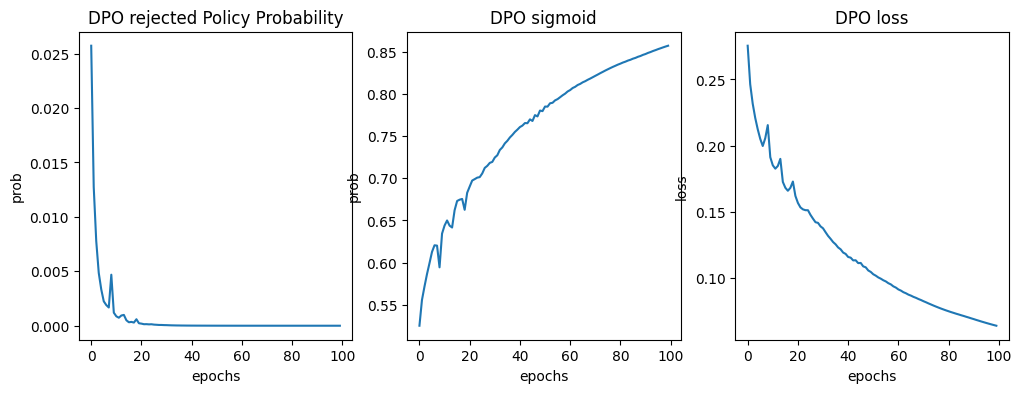

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

x = range(len(neg_poilicy_prob))
y = neg_poilicy_prob
axes[0].plot(x, y)
axes[0].set_title('DPO rejected Policy Probability')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('prob')

x = range(len(logistic_prob))
y = logistic_prob
axes[1].plot(x, y)
axes[1].set_title('DPO sigmoid')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('prob')

x = range(len(loss_record))
y = loss_record
axes[2].plot(x, y)
axes[2].set_title('DPO loss')
axes[2].set_xlabel('epochs')
axes[2].set_ylabel('loss')

# plt.grid(True)
plt.show()

# IPO

IPO的$h_\pi(y, y',x)$可展开成偏好的形式，可以复用DPO的logits计算公式
$$
\begin{align*} h_\pi(y, y',x) &= \log\left( \frac{\pi(y|x)\pi_{ref}(y'|x)}{\pi(y'|x)\pi_{ref}(y|x)} \right) \\
&=\log \frac{\pi(y|x)\pi_{ref}(y'|x)}{\pi_{ref}(y|x)\pi(y'|x)}\\
&= \log \frac{\pi(y|x)}{\pi_{ref}(y|x)} + \log\frac{\pi_{ref}(y'|x)}{\pi(y'|x)} \\
&= \log \frac{\pi(y|x)}{\pi_{ref}(y|x)} - \log\frac{\pi(y'|x)}{\pi_{ref}(y'|x)}
\end{align*}
$$
差异在与DPO的$\beta$ 超参数，在IPO中是$\frac{\tau^{-1}}{2}$​, IPO损失函数是二次的能够收敛

> This simplified form of the loss  provides some valuable insights on the way in which ipo optimizes the policy $\pi$:   ipo learns from preferences dataset simply  by regressing the gap between log-likelihood ratios $\log(\pi(y_{w})/\pi(y_{l}))$ and $\log(\pi_{ref}(y_{w})/\pi_{ref}(y_{l}))$  to $\frac{\tau^{-1}}2$.

$$
\begin{align*}
     \underset{(y_w,y_l,x)\sim D}{\mathbb E} \left(h_\pi(y_{w}, y_{l},x) - \frac{\textcolor{red}{\tau^{-1}}}2\right)^2 .
\end{align*}
$$

In [9]:
def get_logits(model, ref_model, x_chosen, x_rejected):
    # forward get logits
    with torch.no_grad():
        logits_chosen_ref = ref_model(**x_chosen).logits
        logits_rejected_ref = ref_model(**x_rejected).logits
    logits_chosen = model(**x_chosen).logits
    logits_rejected = model(**x_rejected).logits

    # logits to logprob
    probs_chosen_ref = get_probs(logits_chosen_ref, prompt_chosen)
    probs_chosen = get_probs(logits_chosen, prompt_chosen)
    probs_rejected_ref = get_probs(logits_rejected_ref, prompt_rejected)
    probs_rejected = get_probs(logits_rejected, prompt_rejected)

    # loss
    # beta = 0.1
    pi_logratios = probs_chosen - probs_rejected
    ref_logratios = probs_chosen_ref - probs_rejected_ref
    logits = pi_logratios - ref_logratios
    return logits, probs_rejected

In [10]:
# 手撕IPO训练
import torch.optim as optim

def train_XPO(model, beta, loss_type, epochs, lr, optim_type='SGD'):
    # model = LlamaForCausalLM(config)
    if optim_type == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=lr)# 策略会有较多波动
    elif optim_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr) # 实际分析
    epochs_print = epochs//10
    
    neg_poilicy_prob = [] 
    logistic_prob = [] 
    loss_record = []
    for i in range(epochs):
        
        optimizer.zero_grad()
        logits, probs_rejected = get_logits(model, ref_model, x_chosen, x_rejected)

        constant = 1.0 / ( beta * 2.0 ) # IPO
        losses = None
        if loss_type == 'DPO' :
            losses = -F.logsigmoid( beta * logits ) * label
        elif loss_type == 'IPO' :
            losses = torch.square( logits - constant ) * label
            
        loss = losses.sum(-1)/attention_mask.sum()
        neg_poilicy_prob.append(torch.exp(probs_rejected[:,-1]).item())
        # logistic_prob.append(torch.square(logits - constant)[:,-1].item())
        loss_record.append(loss.item())

        # loss back
        loss.backward()
        optimizer.step()
        is_print = False
        if i % epochs_print == 0 & is_print:
            print(f'step {i}, loss:{loss.item()}, pi_rej:{neg_poilicy_prob[-1]}')
    print('-'*50)
    return neg_poilicy_prob, logistic_prob, loss_record

In [11]:
import copy
model = LlamaForCausalLM(config)

In [12]:
epochs = 100
IPO_lr = 0.0001 # IPO lr更低，收敛更低
DPO_lr = 0.01
model_tmp = copy.deepcopy(model)
pi_1, _, _ = train_XPO(model_tmp, 0.1, 'IPO', epochs, IPO_lr) # IPO 用较大学习率容易训飞
model_tmp = copy.deepcopy(model)
pi_2, _, _ = train_XPO(model_tmp, 0.5, 'IPO', epochs, IPO_lr)
model_tmp = copy.deepcopy(model)
pi_3, _, _ = train_XPO(model_tmp, 1.0, 'IPO', epochs, IPO_lr)
model_tmp = copy.deepcopy(model)
pi_4, _, _ = train_XPO(model_tmp, 0.1, 'DPO', epochs, DPO_lr)
model_tmp = copy.deepcopy(model)
pi_5, _, _ = train_XPO(model_tmp, 0.5, 'DPO', epochs, DPO_lr)

step 0, loss:9.241183280944824, pi_rej:0.028185999020934105

step 10, loss:3.000115156173706, pi_rej:0.009844155982136726

step 20, loss:1.5880062580108643, pi_rej:0.00653720973059535

step 30, loss:0.9619183540344238, pi_rej:0.005039808806031942

step 40, loss:0.6139577627182007, pi_rej:0.004204006399959326

step 50, loss:0.40225809812545776, pi_rej:0.003679264336824417

step 60, loss:0.26754266023635864, pi_rej:0.00332315219566226

step 70, loss:0.17960873246192932, pi_rej:0.003068384947255254

step 80, loss:0.12130749225616455, pi_rej:0.002879391424357891

step 90, loss:0.08226241171360016, pi_rej:0.0027355703059583902

--------------------------------------------------

step 0, loss:0.32821744680404663, pi_rej:0.028185999020934105

step 10, loss:0.0698447972536087, pi_rej:0.021184636279940605

step 20, loss:0.015846412628889084, pi_rej:0.018712883815169334

step 30, loss:0.0038118339143693447, pi_rej:0.0176984965801239

step 40, loss:0.000958874064963311, pi_rej:0.017246972769498825

step 50, loss:0.00024955178378149867, pi_rej:0.0170372873544693

step 60, loss:6.668438436463475e-05, pi_rej:0.01693759858608246

step 70, loss:1.8197568351752125e-05, pi_rej:0.01688951440155506

step 80, loss:5.051856078353012e-06, pi_rej:0.016866078600287437

step 90, loss:1.4240991959013627e-06, pi_rej:0.016854582354426384

--------------------------------------------------

step 0, loss:0.1140967383980751, pi_rej:0.028185999020934105

step 10, loss:0.021921474486589432, pi_rej:0.024130914360284805

step 20, loss:0.004328717477619648, pi_rej:0.02248886600136757

step 30, loss:0.0008835766348056495, pi_rej:0.021779734641313553

step 40, loss:0.00018642170471139252, pi_rej:0.021462177857756615

step 50, loss:4.0681905375095084e-05, pi_rej:0.02131732553243637

step 60, loss:9.191646313411184e-06, pi_rej:0.02125060185790062

step 70, loss:2.1525854663195787e-06, pi_rej:0.021219708025455475

step 80, loss:5.233673618931789e-07, pi_rej:0.021205363795161247

step 90, loss:1.3274295440623973e-07, pi_rej:0.02119869738817215

--------------------------------------------------

step 0, loss:0.27308985590934753, pi_rej:0.028185999020934105

step 10, loss:0.24445787072181702, pi_rej:0.013257395476102829

step 20, loss:0.22840695083141327, pi_rej:0.008358149789273739

step 30, loss:0.2178965061903, pi_rej:0.005742396228015423

step 40, loss:0.20973455905914307, pi_rej:0.004138132557272911

step 50, loss:0.20281533896923065, pi_rej:0.0031000615563243628

step 60, loss:0.19664201140403748, pi_rej:0.002389432629570365

step 70, loss:0.19094102084636688, pi_rej:0.0018740908708423376

step 80, loss:0.18554818630218506, pi_rej:0.001482684863731265

step 90, loss:0.18037734925746918, pi_rej:0.0011763381771743298

--------------------------------------------------

step 0, loss:0.25889891386032104, pi_rej:0.028185999020934105

step 10, loss:0.07539781928062439, pi_rej:0.005990082863718271

step 20, loss:0.051763445138931274, pi_rej:0.0036503258161246777

step 30, loss:0.04021027684211731, pi_rej:0.0026391276624053717

step 40, loss:0.03301092982292175, pi_rej:0.0020557024981826544

step 50, loss:0.027989184483885765, pi_rej:0.0016677023377269506

step 60, loss:0.024254828691482544, pi_rej:0.0013887881068512797

step 70, loss:0.0213661827147007, pi_rej:0.0011786238756030798

step 80, loss:0.019072115421295166, pi_rej:0.001015281304717064

step 90, loss:0.01721445843577385, pi_rej:0.0008855166379362345

--------------------------------------------------

# DPO/IPO 收敛情况对比

对于DPO来说$\beta$的取值不影响最后的$\pi(y')$收敛的结果，而IPO则能避免策略收敛到0, 并且$\beta$ 可控收敛到的取值

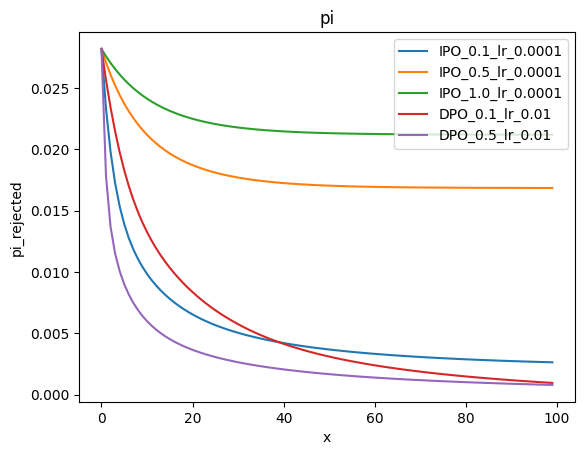

In [13]:
x = range(len(pi_1))
plt.plot(x, pi_1, label='IPO_0.1_lr_0.0001')
plt.plot(x, pi_2, label='IPO_0.5_lr_0.0001')
plt.plot(x, pi_3, label='IPO_1.0_lr_0.0001')
plt.plot(x, pi_4, label='DPO_0.1_lr_0.01')
plt.plot(x, pi_5, label='DPO_0.5_lr_0.01')
plt.legend()
plt.title('pi')
plt.xlabel('x')
plt.ylabel('pi_rejected')
plt.show()

# IPO优化策略稳定性分析

In [14]:
epochs = 100
IPO_lr = 0.0001
DPO_lr = 0.01
model_tmp = copy.deepcopy(model)
pi_1, _, _ = train_XPO(model_tmp, 0.5, 'IPO', epochs, 0.01) # IPO 用较大学习率容易训飞
model_tmp = copy.deepcopy(model)
pi_2, _, _ = train_XPO(model_tmp, 0.5, 'IPO', epochs, 0.001)
model_tmp = copy.deepcopy(model)
pi_3, _, _ = train_XPO(model_tmp, 0.5, 'DPO', epochs, 0.001)
model_tmp = copy.deepcopy(model)
pi_4, _, _ = train_XPO(model_tmp, 0.5, 'IPO', epochs, 0.001, 'ADAM') # IPO 用较大学习率容易训飞

step 0, loss:0.32821744680404663, pi_rej:0.028185999020934105

step 10, loss:0.006162584759294987, pi_rej:0.019381465390324593

step 20, loss:0.0010414734715595841, pi_rej:0.020152214914560318

step 30, loss:0.0001487518020439893, pi_rej:0.02052498236298561

step 40, loss:2.0701951143564656e-05, pi_rej:0.020670507103204727

step 50, loss:2.8750951059919316e-06, pi_rej:0.020725209265947342

step 60, loss:3.9838491261434683e-07, pi_rej:0.02074563503265381

step 70, loss:5.534787916872119e-08, pi_rej:0.020753243938088417

step 80, loss:7.664505474735961e-09, pi_rej:0.0207560695707798

step 90, loss:1.0486758128536167e-09, pi_rej:0.02075713872909546

--------------------------------------------------

step 0, loss:0.32821744680404663, pi_rej:0.028185999020934105

step 10, loss:3.0531963624014224e-09, pi_rej:0.016689235344529152

step 20, loss:6.707523533995563e-13, pi_rej:0.016688941046595573

step 30, loss:6.821210534347505e-14, pi_rej:0.016688941046595573

step 40, loss:2.842170943040401e-14, pi_rej:0.016688933596014977

step 50, loss:1.0800249448028251e-13, pi_rej:0.016688933596014977

step 60, loss:1.1368683941568192e-14, pi_rej:0.016688941046595573

step 70, loss:5.684341886080802e-14, pi_rej:0.01668892428278923

step 80, loss:3.979039252493925e-14, pi_rej:0.016688933596014977

step 90, loss:2.2737367883136385e-14, pi_rej:0.016688941046595573

--------------------------------------------------

step 0, loss:0.25889891386032104, pi_rej:0.028185999020934105

step 10, loss:0.19374188780784607, pi_rej:0.01875227876007557

step 20, loss:0.15519781410694122, pi_rej:0.014312122948467731

step 30, loss:0.1316295564174652, pi_rej:0.011859148740768433

step 40, loss:0.11602728068828583, pi_rej:0.010270449332892895

step 50, loss:0.10484852641820908, pi_rej:0.009122051298618317

step 60, loss:0.09632495790719986, pi_rej:0.00823388621211052

step 70, loss:0.08952262997627258, pi_rej:0.007517651654779911

step 80, loss:0.08390940725803375, pi_rej:0.006923911161720753

step 90, loss:0.07915981113910675, pi_rej:0.006421979051083326

--------------------------------------------------

step 0, loss:0.32821744680404663, pi_rej:0.028185999020934105

step 10, loss:0.00022005513892509043, pi_rej:0.02730717696249485

step 20, loss:0.00636764382943511, pi_rej:0.024495596066117287

step 30, loss:0.0011496776714920998, pi_rej:0.028168324381113052

step 40, loss:0.00025527598336338997, pi_rej:0.027442611753940582

step 50, loss:0.00032119604293257, pi_rej:0.0264128427952528

step 60, loss:3.7737095226475503e-06, pi_rej:0.026918908581137657

step 70, loss:4.166369035374373e-05, pi_rej:0.027181468904018402

step 80, loss:5.102820978208911e-06, pi_rej:0.027070391923189163

step 90, loss:1.4645540886704111e-06, pi_rej:0.026965124532580376

--------------------------------------------------

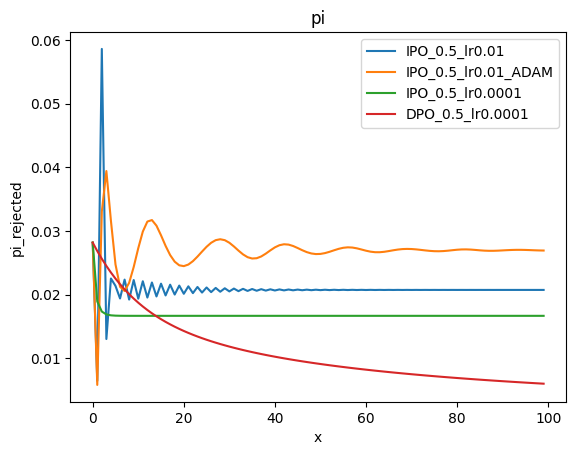

In [15]:
x = range(len(pi_1))
plt.plot(x, pi_1, label='IPO_0.5_lr0.01')
plt.plot(x, pi_4, label='IPO_0.5_lr0.01_ADAM')
plt.plot(x, pi_2, label='IPO_0.5_lr0.0001')
plt.plot(x, pi_3, label='DPO_0.5_lr0.0001')
plt.legend()
plt.title('pi')
plt.xlabel('x')
plt.ylabel('pi_rejected')
plt.show()